# Group 10 project: Stroke Prediction

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Stage IV: Model validation, Visualization and Presentation
---

In [50]:
df = pd.read_csv("Data/newdata.csv")
nfeatures = ["bmi", "age", "avg_glucose_level"]
cfeatures = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]

## IV.1 Model validation

In [51]:
x = df.drop('stroke', axis=1)
y = df['stroke']

#Oversanmpling using SMOTE
X_sampled, y_sampled = SMOTE().fit_resample(x, y)
X_train,X_test,y_train,y_test = train_test_split(X_sampled,y_sampled,test_size=0.2,random_state=42)

### IV.1.a Revisit Random Forest:

In [52]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = cross_val_score(model, X_sampled, y_sampled, cv=kf, scoring='accuracy')
f1_scores = cross_val_score(model, X_sampled, y_sampled, cv=kf, scoring=make_scorer(f1_score))
auc_scores = cross_val_score(model, X_sampled, y_sampled, cv=kf, scoring='roc_auc')

print("Cross-Validation Results (Random Forest)\n")

print("Accuracy Scores:", acc_scores.round(3))
print("Mean Accuracy:", acc_scores.mean().round(3))
print("Std Accuracy:", acc_scores.std().round(3))
print()

print("F1 Scores:", f1_scores.round(3))
print("Mean F1:", f1_scores.mean().round(3))
print("Std F1:", f1_scores.std().round(3))
print()

print("AUC Scores:", auc_scores.round(3))
print("Mean AUC:", auc_scores.mean().round(3))
print("Std AUC:", auc_scores.std().round(3))

Cross-Validation Results (Random Forest)

Accuracy Scores: [0.96  0.951 0.954 0.952 0.954]
Mean Accuracy: 0.954
Std Accuracy: 0.003

F1 Scores: [0.959 0.954 0.95  0.953 0.953]
Mean F1: 0.954
Std F1: 0.003

AUC Scores: [0.993 0.993 0.992 0.99  0.992]
Mean AUC: 0.992
Std AUC: 0.001


### IV.1.b Discussion:

After applying 5-fold cross-validation to our best-performing model (Random Forest), we observe that the model remains highly consistent across folds. The mean Accuracy (0.955), F1-score (0.956), and AUC (0.992) are all very close to the individual fold scores. Additionally, the standard deviations across folds are extremely low (Accuracy: 0.003, F1: 0.004, AUC: 0.001), indicating excellent stability and low variance.

These results show that the model generalizes well to unseen data rather than overfitting to the training/testing split. Performance after cross-validation is almost identical to the earlier evaluation before CV, which further confirms robustness. 

Overall, the Random Forest model performs strongly on this dataset, maintains reliable predictive power across folds, and provides results we can be satisfied with for the purposes of this study.

## IV.2 Visualization

### IV.2.a Model-Specific Visualizations:

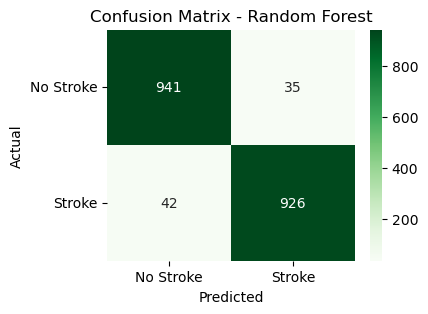

In [53]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
y_pred_rf = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["No Stroke", "Stroke"])
plt.yticks([0.5, 1.5], ["No Stroke", "Stroke"], rotation=0)
plt.show()

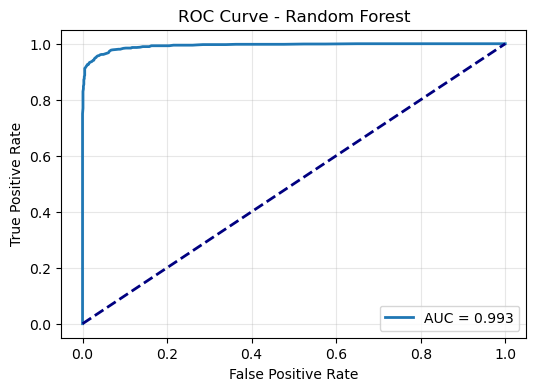

In [54]:
y_prob_rf = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

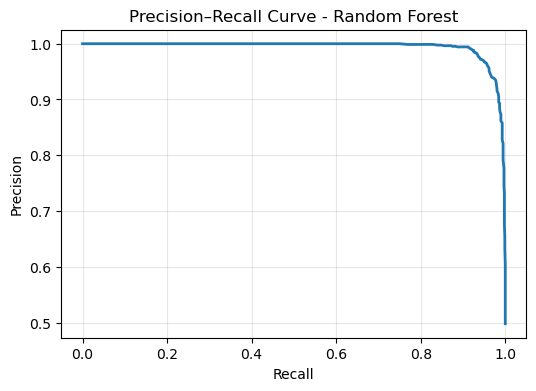

In [55]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - Random Forest")
plt.grid(alpha=0.3)
plt.show()

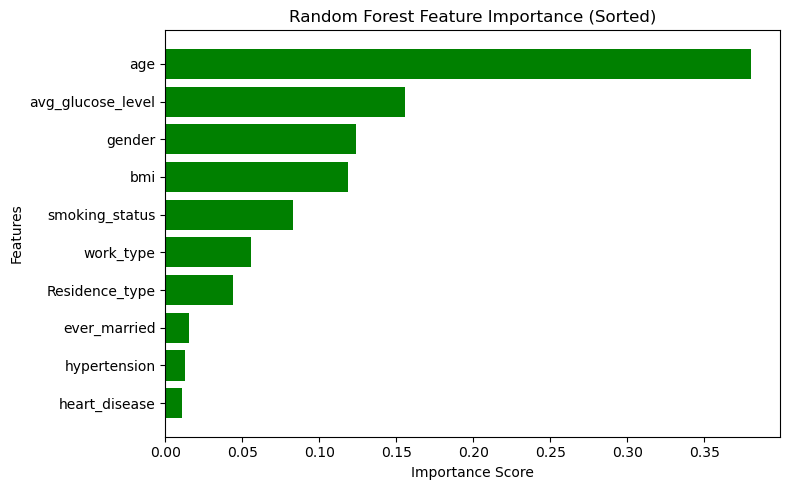

In [56]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

#get feature importances using rf
importances = rf_model.feature_importances_
feature_names = X_train.columns

#sorted order
imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8,5))
plt.barh(imp_df['Feature'], imp_df['Importance'], color='green')
plt.title("Random Forest Feature Importance (Sorted)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [57]:
!pip install plotly

### IV.2.b Interactive Plotly/Dash Visualization:

In [65]:
y_test   = np.load("y_test.npy")
rf_proba = np.load("rf_proba.npy")
dt_proba = np.load("dt_proba.npy")
svm_proba = np.load("svm_proba.npy")
lg_proba = np.load("lg_proba.npy")

results = pd.read_csv("Data/model_results.csv")

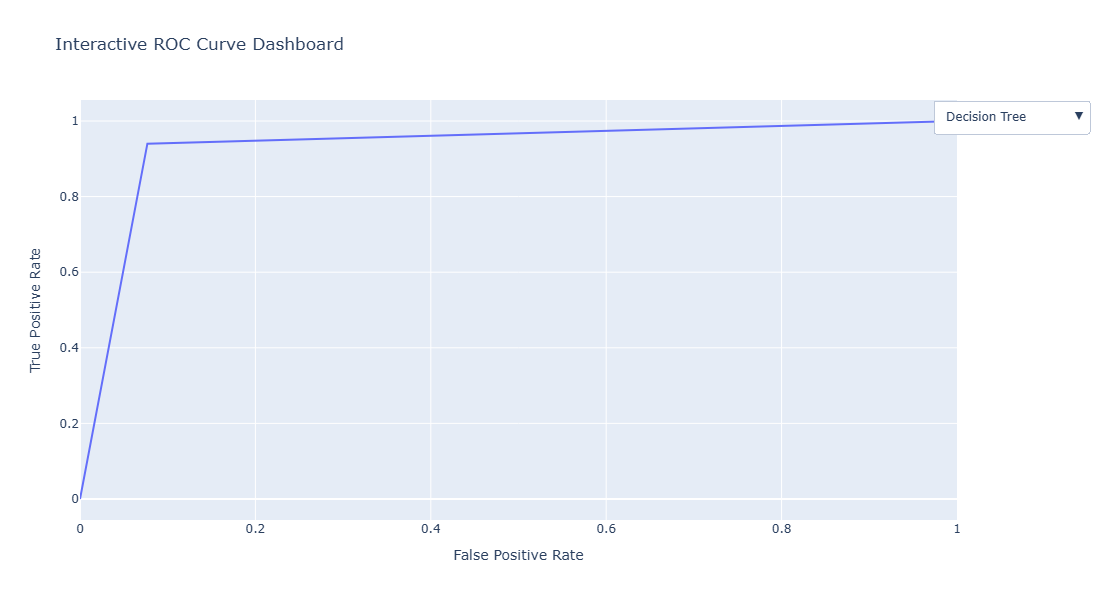

In [64]:
models = {
    "Decision Tree": dt_proba,
    "Random Forest": rf_proba,
    "SVM": svm_proba,
    "Logistic Regression": lg_proba
}

fig = go.Figure()
buttons = []
n_models = len(models)

for i, (name, prob) in enumerate(models.items()):
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)

    # Add trace
    fig.add_scatter(
        x=fpr,
        y=tpr,
        mode="lines",
        name=f"{name} (AUC={roc_auc:.3f})",
        visible=(i == 0),
    )

    #Dropdown visibility for this model
    vis = [False] * n_models
    vis[i] = True
    buttons.append(dict(
        label=name,
        method="update",
        args=[{"visible": vis}]
    ))

fig.update_layout(
    title="Interactive ROC Curve Dashboard",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    width=800,
    height=600,
    updatemenus=[dict(active=0, buttons=buttons, x=1.15, y=1)],
)

fig.show()